In [117]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud

import isodate
import ast
import re
from unidecode import unidecode

import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



# Import necessary libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns


# Import necessary libraries for data selection
from sklearn.feature_selection import chi2

# Import library for data splitting
from sklearn.model_selection import train_test_split

# Import necessary libraries for data modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor, Pool

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import shap

In [33]:
df = pd.read_csv('trending_education_data.csv', parse_dates=['video_trending__date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   video_id                  1774 non-null   object        
 1   video_published_at        1774 non-null   object        
 2   video_trending__date      1774 non-null   datetime64[ns]
 3   video_trending_country    1774 non-null   object        
 4   channel_id                1774 non-null   object        
 5   video_title               1774 non-null   object        
 6   video_description         1763 non-null   object        
 7   video_default_thumbnail   1774 non-null   object        
 8   video_category_id         1774 non-null   object        
 9   video_tags                1252 non-null   object        
 10  video_duration            1774 non-null   object        
 11  video_definition          1774 non-null   object        
 12  video_licensed_conte

In [118]:
df.describe()

video_trending__date  video_licensed_content  \
count                           1774             1774.000000   
mean   2025-02-22 17:42:32.874859264                0.936866   
min              2024-10-12 00:00:00                0.000000   
25%              2024-12-13 00:00:00                1.000000   
50%              2025-02-11 00:00:00                1.000000   
75%              2025-05-09 00:00:00                1.000000   
max              2025-09-11 00:00:00                1.000000   
std                              NaN                0.243273   

       video_view_count  video_like_count  video_comment_count  \
count      1.774000e+03       1774.000000          1774.000000   
mean       1.965714e+06      74323.121195          5642.448703   
min        4.917000e+03          1.000000            58.000000   
25%        5.532358e+05      23341.500000          1842.000000   
50%        1.190533e+06      43234.000000          3608.000000   
75%        2.835081e+06     107482.250000          6970.500000   
max        1.010154e+07     403958.000000         65861.000000   
std        1.980772e+06      74825.571240          7013.174086   

       channel_view_count  channel_subscriber_count  channel_video_count  \
count        1.774000e+03              1.774000e+03          1774.000000   
mean         1.350394e+09              7.710067e+06           509.024803   
min          1.694388e+06              1.530000e+04            21.000000   
25%          2.255947e+08              1.330000e+06           243.000000   
50%          7.286480e+08              4.330000e+06           375.000000   
75%          3.002547e+09              1.697500e+07           485.000000   
max          1.696604e+10              3.080000e+07          5219.000000   
std          1.848711e+09              8.286007e+06           583.739422   

       duration_min  video_title_sentiment  ...  publishing_hour_14  \
count   1774.000000            1774.000000  ...         1774.000000   
mean      21.135269              -0.043692  ...            0.142052   
min        0.283333              -0.906200  ...            0.000000   
25%       13.400000              -0.296000  ...            0.000000   
50%       19.966667               0.000000  ...            0.000000   
75%       26.066667               0.000000  ...            0.000000   
max      251.816667               0.822500  ...            1.000000   
std       18.575965               0.352255  ...            0.349202   

       publishing_hour_15  publishing_hour_16  publishing_hour_17  \
count         1774.000000          1774.00000         1774.000000   
mean             0.188275             0.07159            0.051297   
min              0.000000             0.00000            0.000000   
25%              0.000000             0.00000            0.000000   
50%              0.000000             0.00000            0.000000   
75%              0.000000             0.00000            0.000000   
max              1.000000             1.00000            1.000000   
std              0.391042             0.25788            0.220664   

       publishing_hour_18  publishing_hour_19  publishing_hour_20  \
count         1774.000000         1774.000000         1774.000000   
mean             0.037768            0.083991            0.063134   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%              0.000000            0.000000            0.000000   
75%              0.000000            0.000000            0.000000   
max              1.000000            1.000000            1.000000   
std              0.190688            0.277452            0.243273   

       publishing_hour_21  publishing_hour_22  publishing_hour_23  
count         1774.000000         1774.000000         1774.000000  
mean             0.012401            0.065389            0.011838  
min              0.000000            0.000000            0.000000  
25%

In [18]:
def data_cleaning(df):
    # Remove duplicates
    hashable_cols = [col for col in df.columns if col not in ['tags', 'topic_categories']]
    df_clean = df.drop_duplicates(subset=hashable_cols)

    # Handle missing values
    key_columns = [
                    'video_id',
                    'video_title', 
                    'video_view_count', 
                    'video_like_count', 
                    'video_comment_count',
                    'channel_video_count', 
                    'channel_subscriber_count', 
                    'channel_view_count'
                ]
    df_clean = df_clean.dropna(subset=key_columns)

    # Remove entries with zero video_count, video_view_count, or channel_view_count
    df_clean = df_clean[(df_clean['channel_video_count'] != 0) & (df_clean['video_view_count'] != 0) & (df_clean['channel_view_count'] != 0)]

    


                 

    # Process duration and category   
    
    df_clean['duration_min'] = df_clean['video_duration'].apply(
        lambda x: isodate.parse_duration(x).total_seconds()/60)
    # df_clean['is_high_definition'] = df_clean['video_definition'].apply(lambda x: 1 if x == 'hd' else 0)
    df_clean['video_published_at'] = pd.to_datetime(df_clean['video_published_at'])
    df_clean['channel_published_at'] = df_clean['channel_published_at'].apply(lambda x: re.sub(r'\.\d+Z', 'Z', str(x)))
    df_clean['channel_published_at'] = pd.to_datetime(df_clean['channel_published_at']) 
    

    return df_clean

In [4]:
def normalize_text(text):
    if pd.isna(text):
        return ''
    
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    #  Remove Web links
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def additional_normalize_text(text):
    if pd.isna(text):
        return ''
    
    # Convert accented characters to their ASCII equivalents
    text = unidecode(text)
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def normalize_text_columns(df, function=normalize_text):
    text_columns = ['video_title', 'video_description', 'channel_title', 'channel_description']
    for col in text_columns:
        df[col] = df[col].apply(function)
    return df

In [5]:
def sentiment_enginering(df):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_columns = ['video_title', 'video_description']
    for col in sentiment_columns:
        df[f'{col}_sentiment'] = df[col].apply(lambda x: analyzer.polarity_scores(x)["compound"])
        # df[f'has_emoji_in_{col}'] = df[col].apply(lambda x: 1 if any(char in emoji.EMOJI_DATA for char in x) else 0)
        df[f'count_of_emoji_in_{col}'] = df[col].apply(lambda x: sum(1 for char in x if char in emoji.EMOJI_DATA)) 
    return df

In [10]:
def model_feature_engineering(df):

    df['publishing_day'] = df['video_published_at'].apply(lambda x: pd.to_datetime(x).day_name())
    df['publishing_hour'] = df['video_published_at'].apply(lambda x: pd.to_datetime(x).hour)

    df['video_age_days'] = (pd.to_datetime(df['video_trending__date'], utc=True) - pd.to_datetime(df['video_published_at'])).dt.total_seconds() / (24 * 3600)  
    df['channel_age_days'] = (pd.to_datetime(df['video_trending__date'], utc=True) - pd.to_datetime(df['channel_published_at'])).dt.total_seconds() / (24 * 3600) 

    # df['has_tags'] = df['video_tags'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '[]' else 1)
    df['counts_of_tags'] = df['video_tags'].apply(lambda x: 0 if pd.isna(x) else len(str(x).split(',')))
    
    # df['has_video_description'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else 1)
    # df['has_channel_description'] = df['channel_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else 1)    
    df['word_count_in_title'] = df['video_title'].apply(lambda x: len(x.split()))
    df['word_count_in_description'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x.split()))
    df['word_count_in_channel_title'] = df['channel_title'].apply(lambda x: len(x.split())) 
    df['word_count_in_channel_description'] = df['channel_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x.split()))
    # df['character_count_in_title'] = df['video_title'].apply(lambda x: len(x))
    # df['character_count_in_description'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x))
    

    # df['titile_sentiment'] = df['video_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
    # df['description_sentiment'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else TextBlob(x).sentiment.polarity)

    return df


In [34]:
df = data_cleaning(df)
df = normalize_text_columns(df, function=normalize_text)
df = sentiment_enginering(df)
df = normalize_text_columns(df, function=additional_normalize_text)
dfoo = df.copy()
df = model_feature_engineering(df)
dfo = df.copy()
df.head()


video_id        video_published_at video_trending__date  \
0  2j8xJ9oizBQ 2024-10-12 15:00:31+00:00           2024-10-12   
1  q7jlmtxSUuQ 2024-10-11 20:08:56+00:00           2024-10-12   
2  5qxssFQv1o4 2024-10-10 22:10:27+00:00           2024-10-12   
3  JrO_tvMjqjo 2024-10-08 13:23:50+00:00           2024-10-12   
4  cUBz04LlLVk 2024-10-05 17:27:38+00:00           2024-10-12   

  video_trending_country                channel_id  \
0                 Canada  UCQF0f62JXnfFSxKDmN8SDUg   
1                 Canada  UCRlICXvO4XR4HMeEB9JjDlA   
2                 Canada  UC41M8ZcIBLvEH_O3O6qMUAg   
3                 Canada  UC9RM-iSvTu1uPJb8X5yp3EQ   
4                 Canada  UCHnyfMqiRRG1u-2MsSQLbXA   

                                         video_title  \
0                                the big bang part 2   
1  weve just found a new type of star and its ter...   
2  inside intense hurricane shocking aftermath fo...   
3                          hawaiis logistics problem   
4  people said this experiment was impossible so ...   

                                   video_description  \
0  get early access to episodes perks support the...   
1  get started with odoo for free today thoughty2...   
2  we went through the eye of the storm and then ...   
3  how balanced is your news diet go to to get 40...   
4  the worlds first look inside a thermite reacti...   

                          video_default_thumbnail video_category_id  \
0  https://i.ytimg.com/vi/2j8xJ9oizBQ/default.jpg         Education   
1  https://i.ytimg.com/vi/q7jlmtxSUuQ/default.jpg         Education   
2  https://i.ytimg.com/vi/5qxssFQv1o4/default.jpg         Education   
3  https://i.ytimg.com/vi/JrO_tvMjqjo/default.jpg         Education   
4  https://i.ytimg.com/vi/cUBz04LlLVk/default.jpg         Education   

                                          video_tags  ...  \
0  solarballs,solarball,cosmos,scifi,sci fi,space...  ...   
1                                                NaN  ...   
2  God,Jesus,Holy Spirit,Christ,Christian,Christi...  ...   
3                                                NaN  ...   
4  Science,veritasium,robert bunsen,metallurgy,ha...  ...   

  count_of_emoji_in_video_description publishing_day  publishing_hour  \
0                                   0       Saturday               15   
1                                   0         Friday               20   
2                                   0       Thursday               22   
3                                   0        Tuesday               13   
4                                   0       Saturday               17   

   video_age_days  channel_age_days  counts_of_tags word_count_in_title  \
0       -0.625359        890.341354              27                   5   
1        0.160463       4382.221204               0                  11   
2        1.076076       4759.172685               8                   6   
3        3.441782       5356.442303               0                   3   
4        6.272477       5196.695810               9                  10   

  word_count_in_description word_count_in_channel_title  \
0                       134                           1   
1                        51                           1   
2                        59                           3   
3                        73                           2   
4                       399                           1   

  word_count_in_channel_description  
0                               120  
1                                85  
2                                44  
3                                40  
4                                14  

[5 rows x 37 columns]

count_of_emoji_in_video_title
0    1774
Name: count, dtype: int64

In [35]:
dfo = df.copy()

In [13]:
def data_encoding(df):
    # One-hot encode categorical variables
    one_hot_columns = ['publishing_day', 'publishing_hour']
    df = pd.get_dummies(df, columns=one_hot_columns, drop_first=False)

    return df

In [36]:
df = data_encoding(df)
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

In [37]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 65 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   video_id                             1774 non-null   object             
 1   video_published_at                   1774 non-null   datetime64[ns, UTC]
 2   video_trending__date                 1774 non-null   datetime64[ns]     
 3   video_trending_country               1774 non-null   object             
 4   channel_id                           1774 non-null   object             
 5   video_title                          1774 non-null   object             
 6   video_description                    1774 non-null   object             
 7   video_default_thumbnail              1774 non-null   object             
 8   video_category_id                    1774 non-null   object             
 9   video_tags                    

EDA

<Axes: >

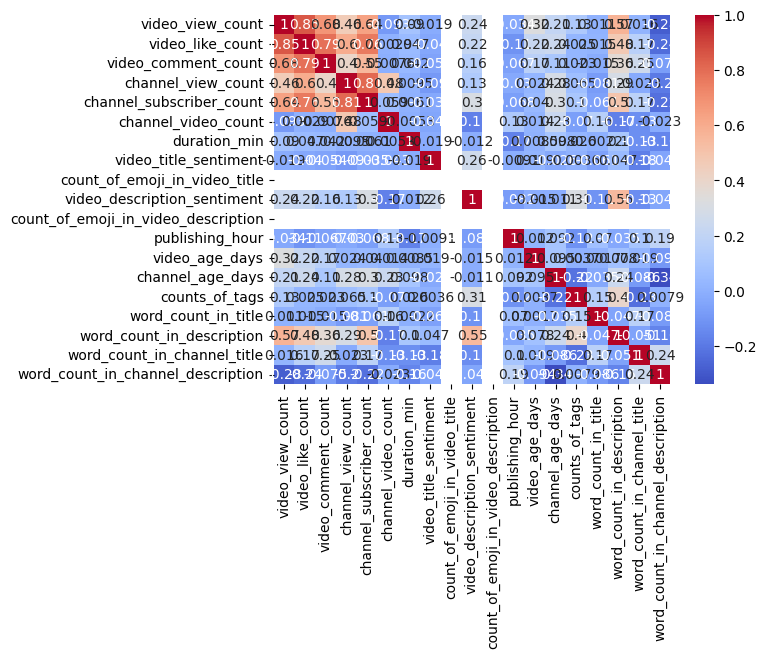

In [38]:
# heatmap for correlation
numeric_cols = dfo.select_dtypes(include='number').columns.tolist()
categorical_cols = dfo.select_dtypes(include=['object', 'category']).columns.tolist()

sns.heatmap(dfo[numeric_cols].corr(), annot=True, cmap='coolwarm')



In [ ]:
df.head

<Axes: >

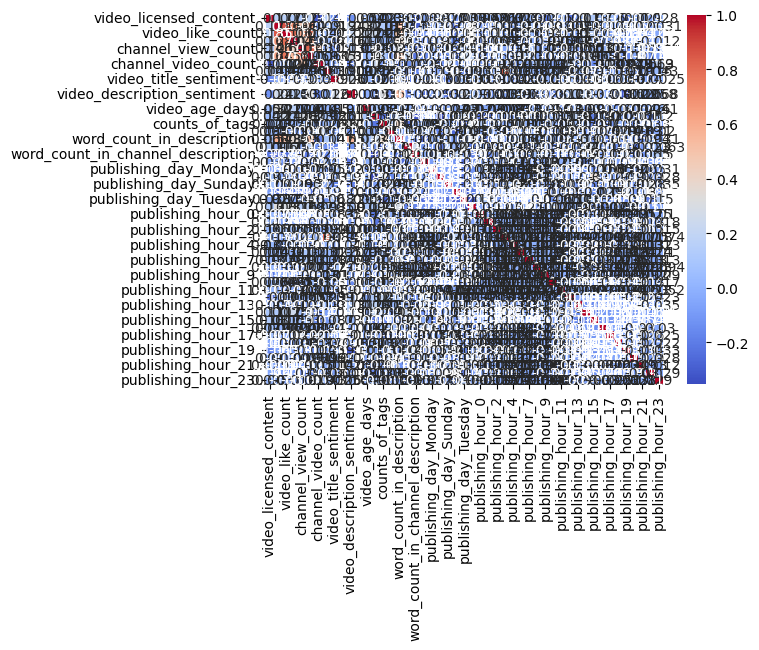

In [42]:
# heatmap for correlation
numeric_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')



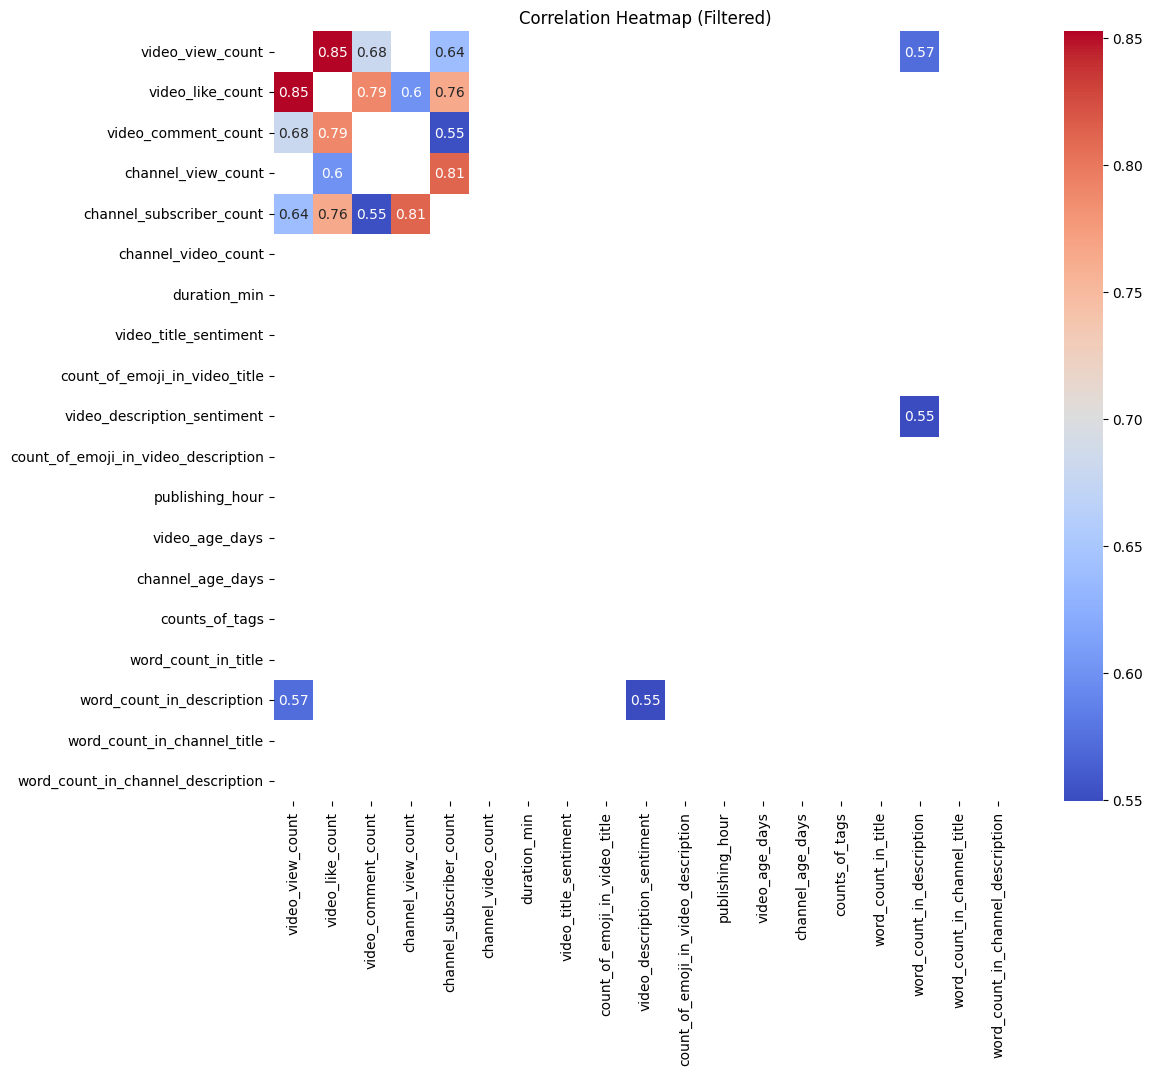

In [39]:
filtered_heatmap = dfo[numeric_cols].corr().abs()
filtered_heatmap = (filtered_heatmap > 0.5) & (filtered_heatmap < 1.0)
plt.figure(figsize=(12, 10))
sns.heatmap(dfo[numeric_cols].corr(), annot=True, cmap='coolwarm', mask=~filtered_heatmap)
plt.title('Correlation Heatmap (Filtered)')
plt.show()  

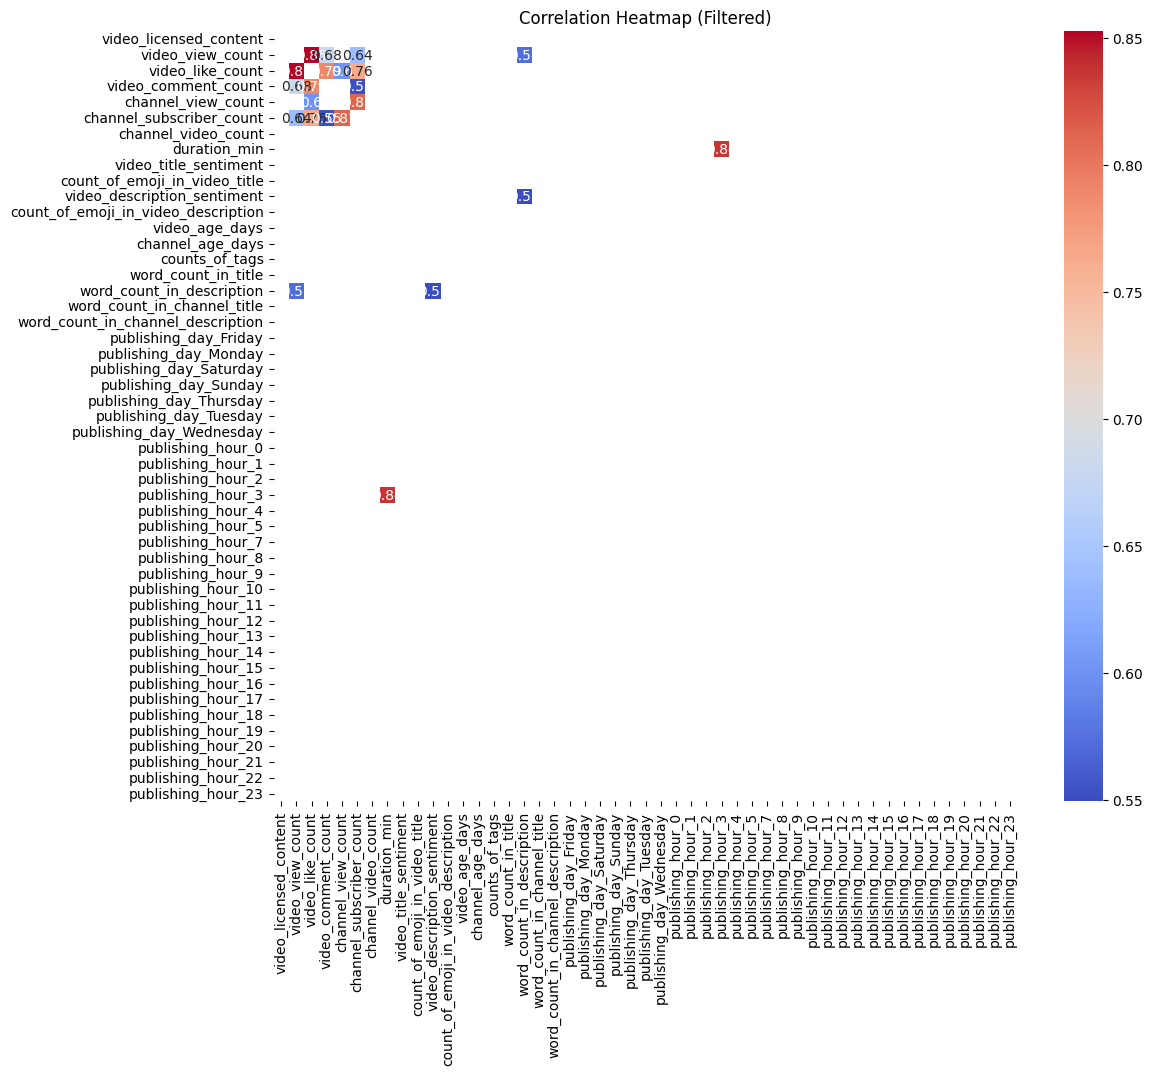

In [43]:
filtered_heatmap = df[numeric_cols].corr().abs()
filtered_heatmap = (filtered_heatmap > 0.5) & (filtered_heatmap < 1.0)
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', mask=~filtered_heatmap)
plt.title('Correlation Heatmap (Filtered)')
plt.show()  

In [28]:
numeric_cols

['rank',
 'category_id',
 'video_view_count',
 'video_like_count',
 'video_comment_count',
 'channel_view_count',
 'subscriber_count',
 'video_count',
 'duration_min',
 'is_high_definition',
 'has_tags',
 'counts_of_tags',
 'has_topic_categories',
 'counts_of_topic_categories',
 'has_video_description',
 'has_channel_description',
 'word_count_in_title',
 'word_count_in_description',
 'word_count_in_channel_title',
 'word_count_in_channel_description',
 'titile_sentiment',
 'description_sentiment']

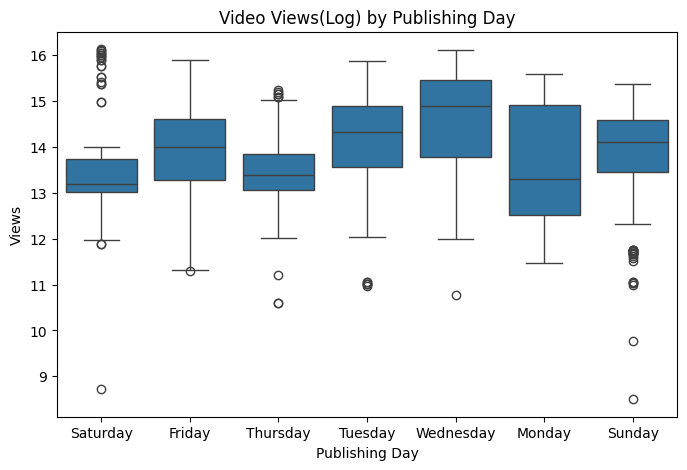

In [41]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_day', y=np.log(dfo['video_view_count']), data=dfo)
plt.title("Video Views(Log) by Publishing Day")
plt.ylabel("Views")
plt.xlabel("Publishing Day")
plt.show()

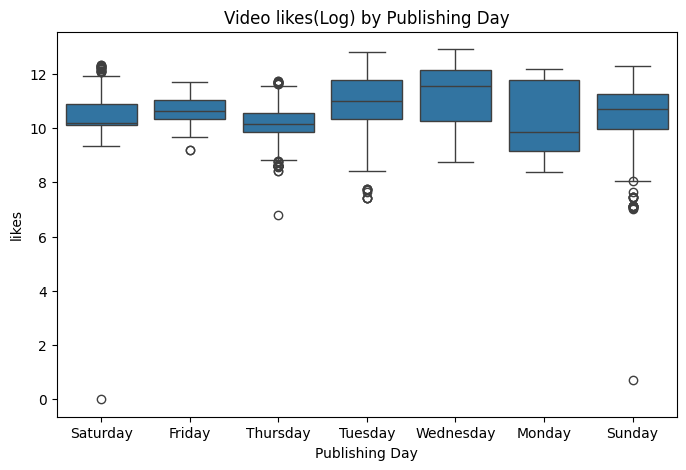

In [44]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_day', y=np.log(dfo['video_like_count']), data=dfo)
plt.title("Video likes(Log) by Publishing Day")
plt.ylabel("likes")
plt.xlabel("Publishing Day")
plt.show()

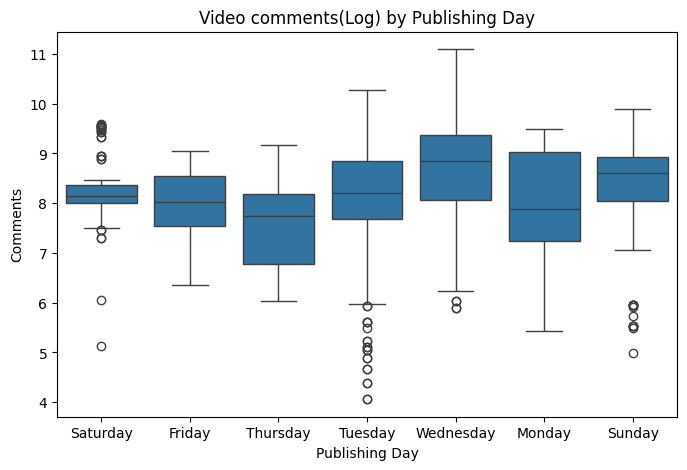

In [45]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_day', y=np.log(dfo['video_comment_count']), data=dfo)
plt.title("Video comments(Log) by Publishing Day")
plt.ylabel("Comments")
plt.xlabel("Publishing Day")
plt.show()

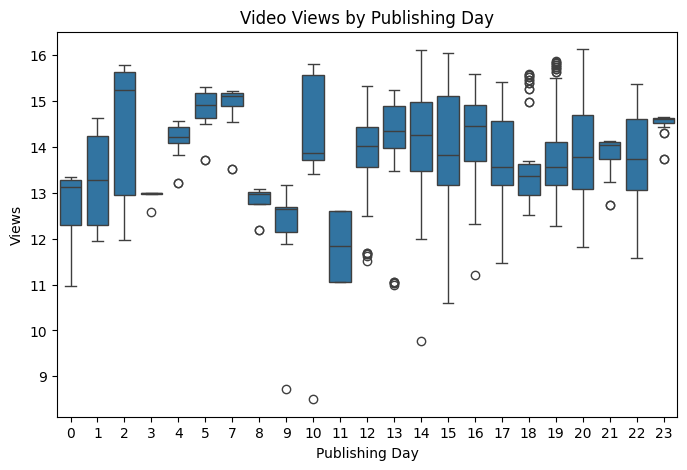

In [46]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_hour', y=np.log(dfo['video_view_count']), data=dfo)
plt.title("Video Views by Publishing Day")
plt.ylabel("Views")
plt.xlabel("Publishing Day")
plt.show()

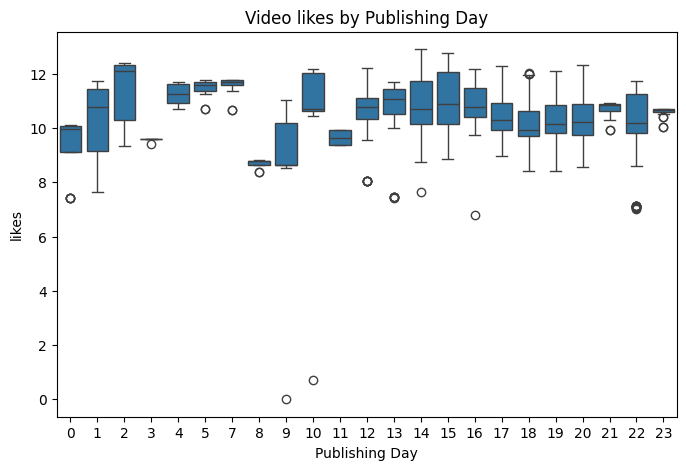

In [33]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_hour', y=np.log(dfo['video_like_count']), data=dfo)
plt.title("Video likes by Publishing Day")
plt.ylabel("likes")
plt.xlabel("Publishing Day")
plt.show()

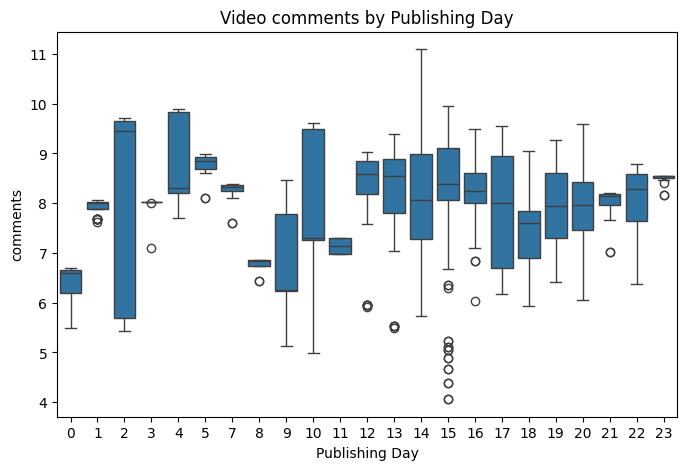

In [34]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_hour', y=np.log(dfo['video_comment_count']), data=dfo)
plt.title("Video comments by Publishing Day")
plt.ylabel("comments")
plt.xlabel("Publishing Day")
plt.show()

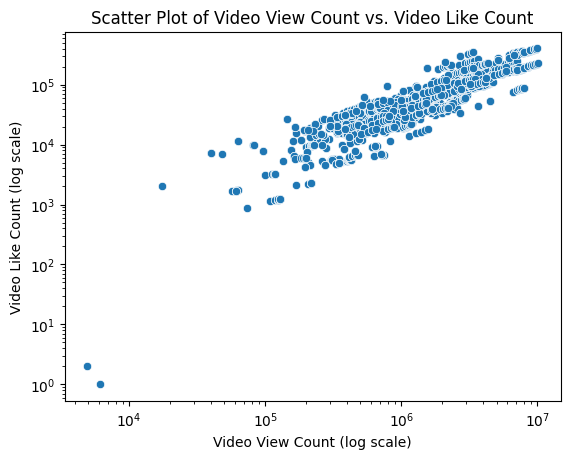

In [35]:
sns.scatterplot(x='video_view_count', y='video_like_count', data=dfo)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Video View Count (log scale)')
plt.ylabel('Video Like Count (log scale)')
plt.title('Scatter Plot of Video View Count vs. Video Like Count')
plt.show()


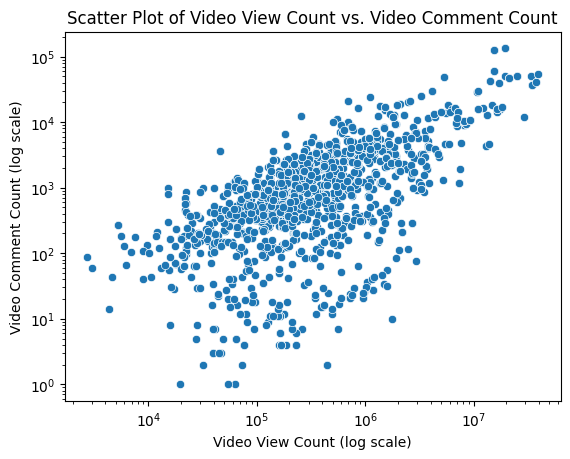

In [48]:
sns.scatterplot(x='video_view_count', y='video_comment_count', data=dfo)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Video View Count (log scale)')
plt.ylabel('Video Comment Count (log scale)')
plt.title('Scatter Plot of Video View Count vs. Video Comment Count')
plt.show()               

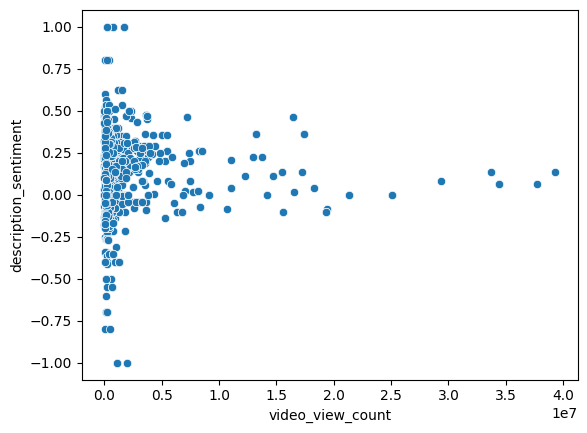

In [75]:
sns.scatterplot(x='video_view_count', y='description_sentiment', data=dfo)
plt.show()




In [36]:
dfo.columns

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_published_at', 'channel_country', 'channel_view_count',
       'channel_subscriber_count', 'channel_video_count', 'duration_min',
       'is_high_definition', 'publishing_day', 'publishing_hour', 'has_tags',
       'counts_of_tags', 'has_video_description', 'has_channel_description',
       'word_count_in_title', 'word_count_in_description',
       'word_count_in_channel_title', 'word_count_in_channel_description',
       'titile_sentiment', 'description_sentiment'],
      dtype='object')

In [37]:
df.describe()

video_trending__date  video_view_count  video_like_count  \
count                           1774      1.774000e+03       1774.000000   
mean   2025-02-22 17:42:32.874859264      1.965714e+06      74323.121195   
min              2024-10-12 00:00:00      4.917000e+03          1.000000   
25%              2024-12-13 00:00:00      5.532358e+05      23341.500000   
50%              2025-02-11 00:00:00      1.190533e+06      43234.000000   
75%              2025-05-09 00:00:00      2.835081e+06     107482.250000   
max              2025-09-11 00:00:00      1.010154e+07     403958.000000   
std                              NaN      1.980772e+06      74825.571240   

       video_comment_count  channel_view_count  channel_subscriber_count  \
count          1774.000000        1.774000e+03              1.774000e+03   
mean           5642.448703        1.350394e+09              7.710067e+06   
min              58.000000        1.694388e+06              1.530000e+04   
25%            1842.000000        2.255947e+08              1.330000e+06   
50%            3608.000000        7.286480e+08              4.330000e+06   
75%            6970.500000        3.002547e+09              1.697500e+07   
max           65861.000000        1.696604e+10              3.080000e+07   
std            7013.174086        1.848711e+09              8.286007e+06   

       channel_video_count  duration_min  is_high_definition     has_tags  \
count          1774.000000   1774.000000              1774.0  1774.000000   
mean            509.024803     21.135269                 1.0     0.705750   
min              21.000000      0.283333                 1.0     0.000000   
25%             243.000000     13.400000                 1.0     0.000000   
50%             375.000000     19.966667                 1.0     1.000000   
75%             485.000000     26.066667                 1.0     1.000000   
max            5219.000000    251.816667                 1.0     1.000000   
std             583.739422     18.575965                 0.0     0.455834   

       counts_of_tags  has_video_description  has_channel_description  \
count     1774.000000            1774.000000              1774.000000   
mean        14.179820               0.993799                 0.974634   
min          0.000000               0.000000                 0.000000   
25%          0.000000               1.000000                 1.000000   
50%         14.000000               1.000000                 1.000000   
75%         24.000000               1.000000                 1.000000   
max         45.000000               1.000000                 1.000000   
std         13.120717               0.078522                 0.157280   

       word_count_in_title  word_count_in_description  \
count          1774.000000                1774.000000   
mean              7.466178                 258.233935   
min               3.000000                   0.000000   
25%               6.000000                 105.000000   
50%               7.000000                 257.000000   
75%               9.000000                 372.000000   
max              16.000000                 691.000000   
std               2.599782                 166.283600   

       word_count_in_channel_title  word_count_in_channel_description  \
count                  1774.000000                        1774.000000   
mean                      2.065389                          50.864149   
min                       1.000000                           0.000000   
25%                       1.000000                          14.000000   
50%                       2.000000                          42.000000   
75%                       2.000000                          66.000000   
max                       6.000000                         175.000000   
std                       1.131115                          41.249959   

       titile_sentiment  description_sentiment  
count       1774.000000            1774.000000  
mean          -0.004137 

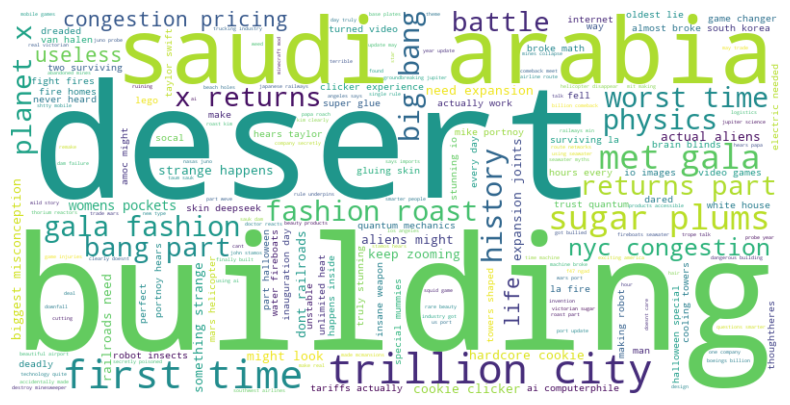

In [47]:
text = ' '.join(dfo['video_title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

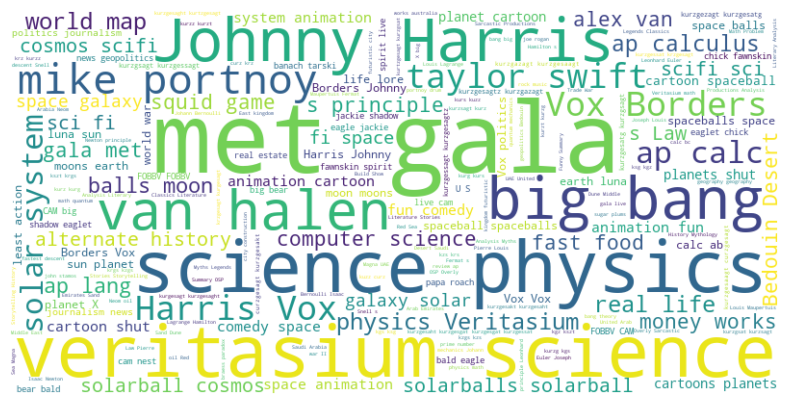

In [48]:
all_tags = ' '.join(dfo['video_tags'].dropna())
wordcloud_tags = WordCloud(width=800, height=400, background_color='white').generate(all_tags)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tags, interpolation='bilinear')
plt.axis('off')
plt.show()

In [50]:
dfo['video_definition'].value_counts()

video_definition
hd    1774
Name: count, dtype: int64

In [51]:
df.columns

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_published_at', 'channel_country', 'channel_view_count',
       'channel_subscriber_count', 'channel_video_count', 'duration_min',
       'video_title_sentiment', 'count_of_emoji_in_video_title',
       'video_description_sentiment', 'count_of_emoji_in_video_description',
       'video_age_days', 'channel_age_days', 'counts_of_tags',
       'word_count_in_title', 'word_count_in_description',
       'word_count_in_channel_title', 'word_count_in_channel_description',
       'publishing_day_Friday', 'publishing_day_Monday',
       'publishing_day_Saturday', 'publishing_day_Sun

In [52]:
df_model = df[[
 
 'video_licensed_content',
 'video_view_count',
 'video_like_count',
 'video_comment_count',
 'channel_view_count',
 'channel_subscriber_count',
 'channel_video_count',
 'duration_min',
 'video_title_sentiment', 
       'video_description_sentiment',
 
 'video_age_days', 'channel_age_days',
 'counts_of_tags',

 
 
 'word_count_in_title',
 'word_count_in_description',
 'word_count_in_channel_title',
 'word_count_in_channel_description',
 'publishing_day_Friday',
 'publishing_day_Monday',
 'publishing_day_Saturday',
 'publishing_day_Sunday',
 'publishing_day_Thursday',
 'publishing_day_Tuesday',
 'publishing_day_Wednesday',
 'publishing_hour_0',
 'publishing_hour_1',
 'publishing_hour_2',
 'publishing_hour_3',
 'publishing_hour_4',
 'publishing_hour_5',
 
 'publishing_hour_7',
 'publishing_hour_8',
 'publishing_hour_9',
 'publishing_hour_10',
 'publishing_hour_11',
 'publishing_hour_12',
 'publishing_hour_13',
 'publishing_hour_14',
 'publishing_hour_15',
 'publishing_hour_16',
 'publishing_hour_17',
 'publishing_hour_18',
 'publishing_hour_19',
 'publishing_hour_20',
 'publishing_hour_21',
 'publishing_hour_22',
 'publishing_hour_23',
 ]]

len(df_model.columns)

47

In [53]:
output_cols =[
 'video_view_count',
 'video_like_count',
 'video_comment_count',
 'channel_view_count',
 'channel_subscriber_count']

In [54]:
df_output = df[output_cols]
df_output['engaging_count']= df['video_like_count'] + df['video_comment_count']
df_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   video_view_count          1774 non-null   float64
 1   video_like_count          1774 non-null   float64
 2   video_comment_count       1774 non-null   float64
 3   channel_view_count        1774 non-null   float64
 4   channel_subscriber_count  1774 non-null   float64
 5   engaging_count            1774 non-null   float64
dtypes: float64(6)
memory usage: 83.3 KB


/var/folders/kg/0rnyb9h57zjgz1rz383bzj380000gn/T/ipykernel_26546/2188801542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['engaging_count']= df['video_like_count'] + df['video_comment_count']


In [55]:
df_model = df_model.drop(columns=output_cols)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   video_licensed_content             1774 non-null   int64  
 1   channel_video_count                1774 non-null   float64
 2   duration_min                       1774 non-null   float64
 3   video_title_sentiment              1774 non-null   float64
 4   video_description_sentiment        1774 non-null   float64
 5   video_age_days                     1774 non-null   float64
 6   channel_age_days                   1774 non-null   float64
 7   counts_of_tags                     1774 non-null   int64  
 8   word_count_in_title                1774 non-null   int64  
 9   word_count_in_description          1774 non-null   int64  
 10  word_count_in_channel_title        1774 non-null   int64  
 11  word_count_in_channel_description  1774 non-null   int64

In [133]:
X = df_model
y = df_output['video_view_count'].apply(lambda x: np.log(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [ ]:
# Define a functio to train the model and display metric evaluations
def train_model(model, X_train=X_train, y_train=y_train):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    r2 = r2_score(y_test, y_predict)
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mse) 

    print(f'R^2: {r2}')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
   

In [123]:
random_forest_model_view = RandomForestRegressor(random_state=9)
random_forest_model_view

RandomForestRegressor(random_state=9)

In [134]:
# train the model
train_model(model=random_forest_model_view, X_train=X_train, y_train=y_train)

R^2: 0.9904827166329689
MAE: 0.05071209589721106
MSE: 0.008959613214420903
RMSE: 0.0946552334233079


/var/folders/kg/0rnyb9h57zjgz1rz383bzj380000gn/T/ipykernel_26546/2773218112.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10), palette='viridis' )


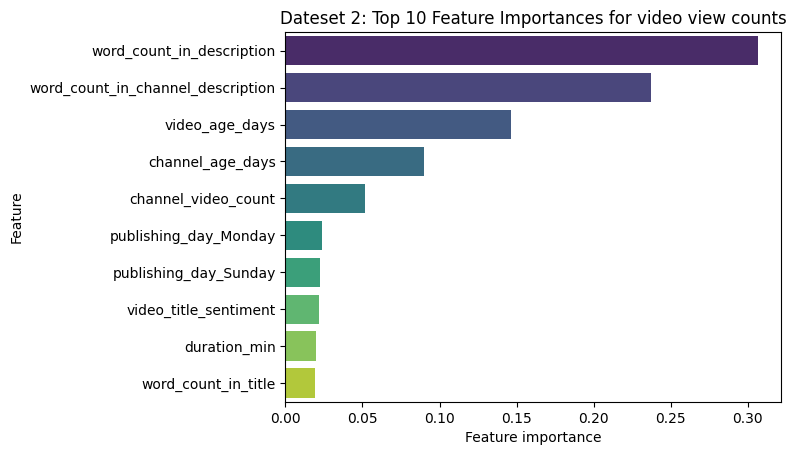

In [ ]:

feature_importance = random_forest_model_view.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Feature importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Feature importance', ascending=False)
sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10), palette='viridis' )
plt.title('Dateset 2: Top 10 Feature Importances for video view counts')
plt.show()

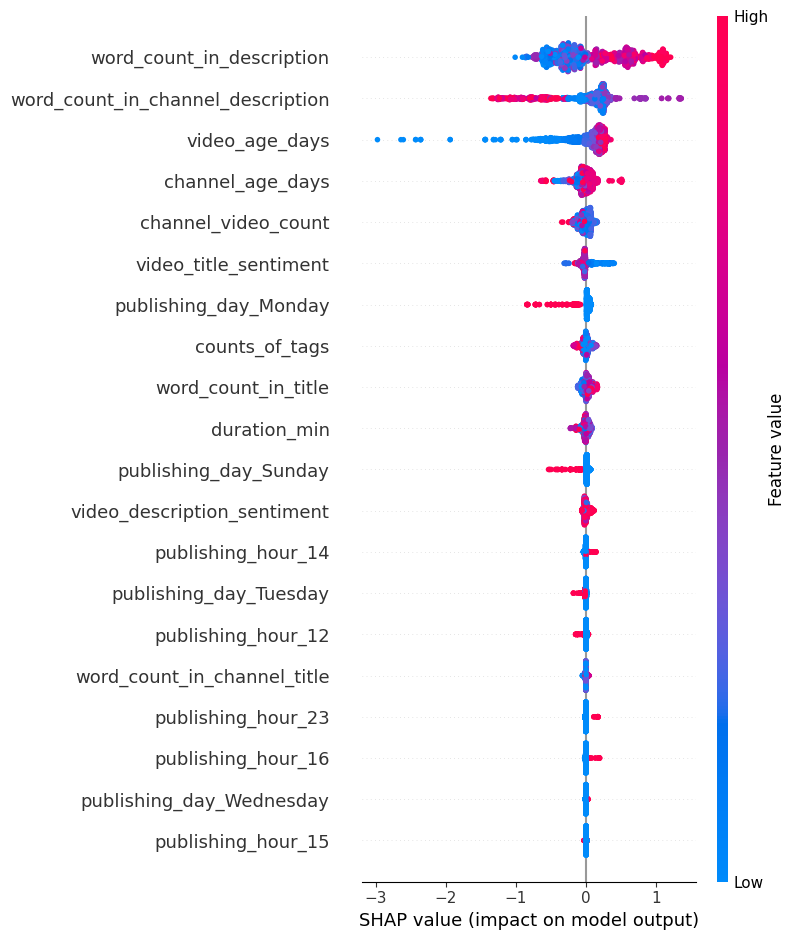

In [65]:
import shap

explainer = shap.TreeExplainer(random_forest_model_view)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [66]:
X = df_model
y = df_output['engaging_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [67]:

random_forest_model_engaging = RandomForestRegressor(random_state=9)
random_forest_model_engaging

RandomForestRegressor(random_state=9)

In [68]:
# train the model
train_model(model=random_forest_model_engaging, X_train=X_train, y_train=y_train)

R^2: 0.9972785954382739
MAE: 2152.9474272412253
MSE: 14733691.9690438
RMSE: 3838.449161972033


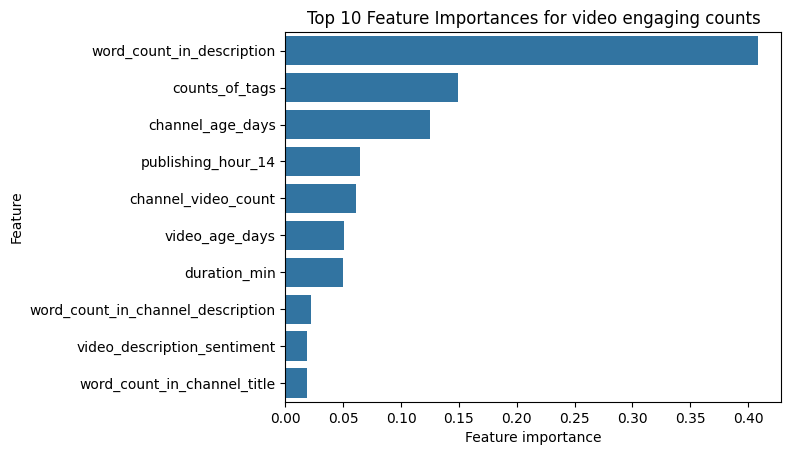

In [ ]:
feature_importance = random_forest_model_engaging.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Feature importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Feature importance', ascending=False)
sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10) )
plt.title('Top 10 Feature Importances for video engaging counts')
plt.show()

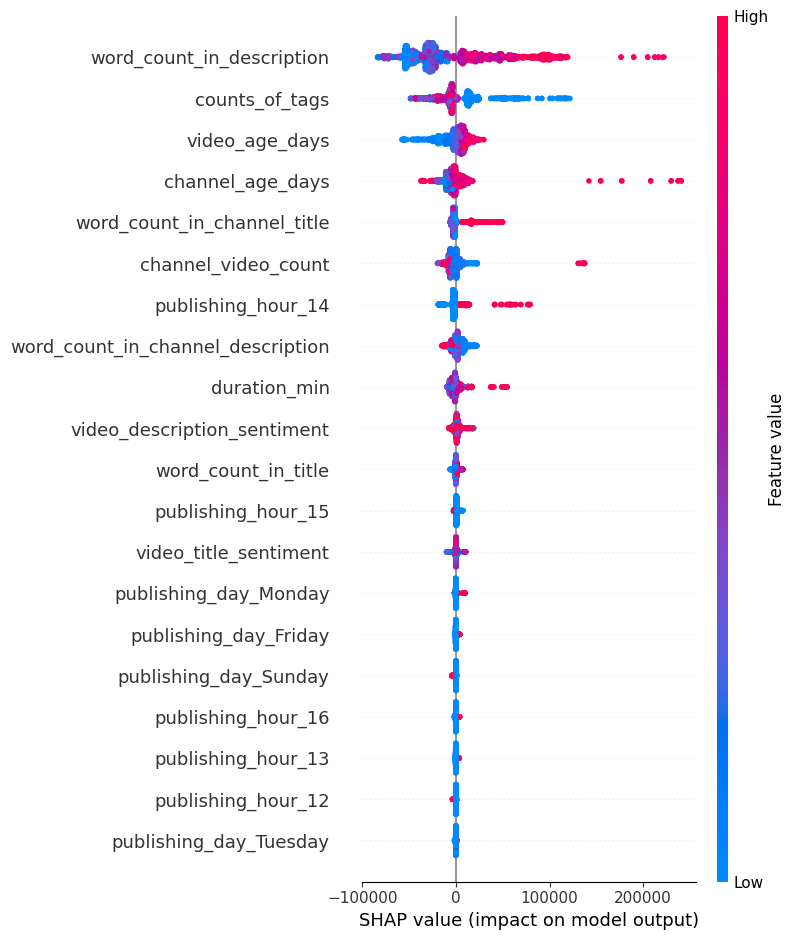

In [76]:
import shap

explainer = shap.TreeExplainer(random_forest_model_engaging)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [77]:
X = df_model
y = df_output['channel_subscriber_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [78]:
random_forest_model_subscriber = RandomForestRegressor(random_state=9)
random_forest_model_subscriber

RandomForestRegressor(random_state=9)

In [79]:
# train the model
train_model(model=random_forest_model_subscriber, X_train=X_train, y_train=y_train)

R^2: 0.9987862996206416
MAE: 33960.72394366197
MSE: 80178060412.44226
RMSE: 283157.30683216045


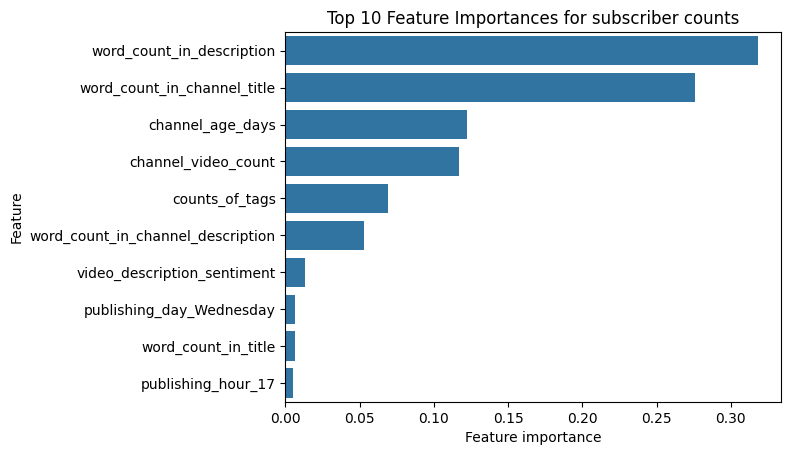

In [ ]:
feature_importance = random_forest_model_subscriber.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Feature importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Feature importance', ascending=False)
sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10) )
plt.title('Top 10 Feature Importances for subscriber counts')
plt.show()

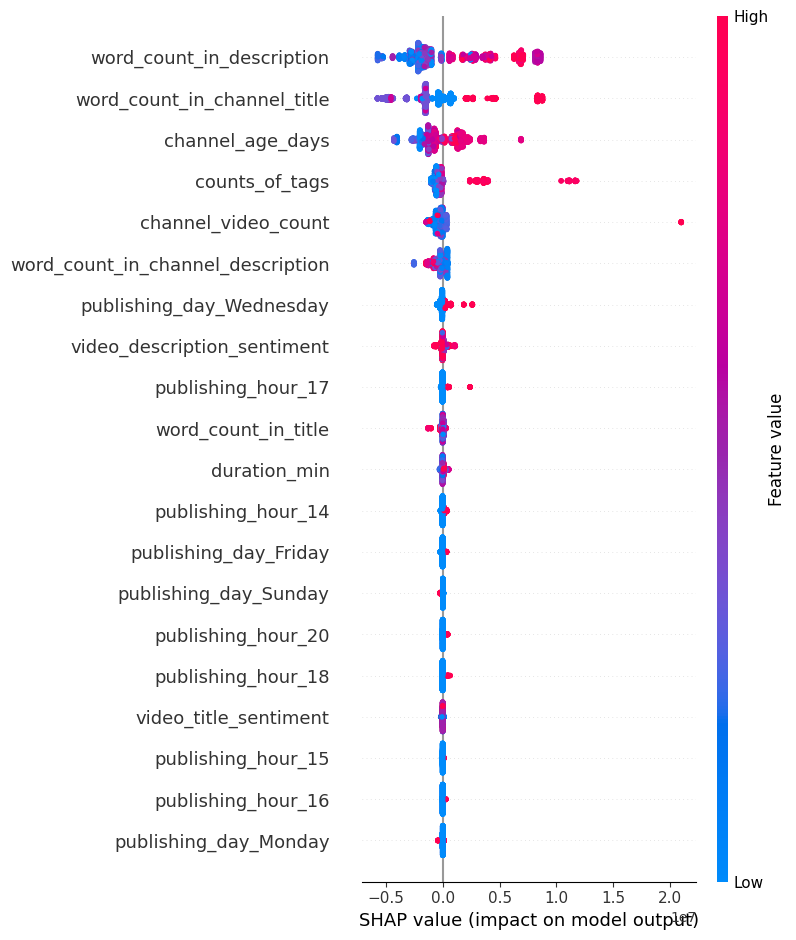

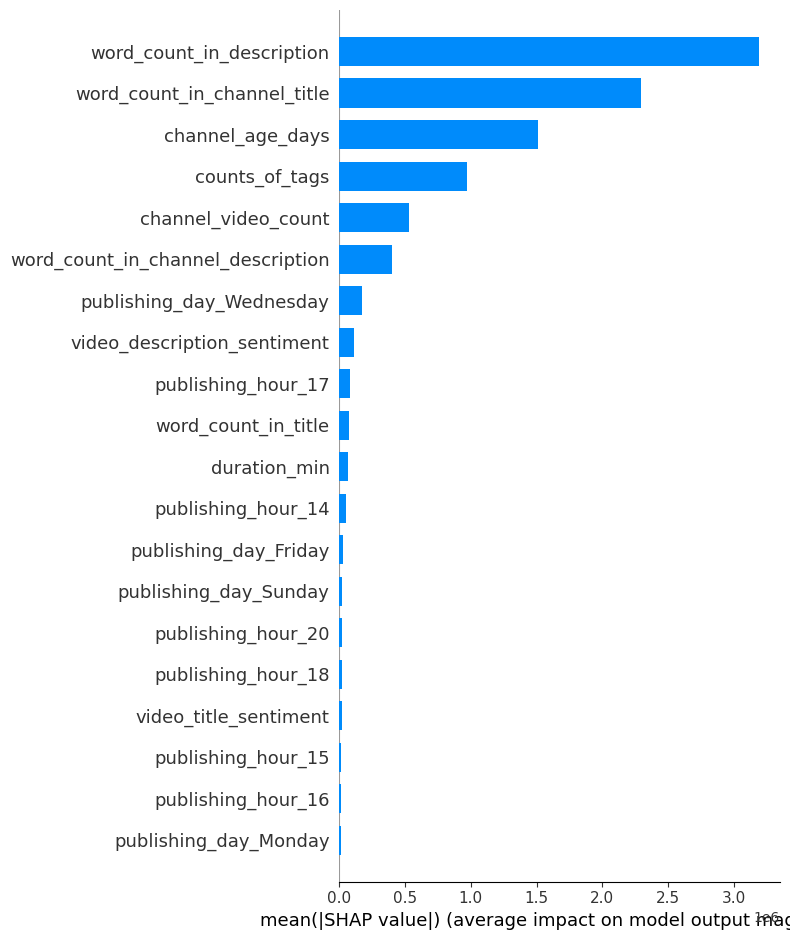

In [ ]:
explainer = shap.TreeExplainer(random_forest_model_subscriber)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


In [101]:
catboost_categorical_cols = [
 'video_title',
 'video_description',
 'video_tags',
 'channel_title',
 'channel_description',]

In [96]:
df_catboost_model = df[[
        'video_title',
       'video_description', 
       'video_tags', 
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
  'channel_view_count',
       'channel_subscriber_count', 'channel_video_count', 'duration_min',
        'video_title_sentiment', 
       'video_description_sentiment', 
       'video_age_days', 'channel_age_days', 'counts_of_tags',
       
       'word_count_in_title', 'word_count_in_description',
       'word_count_in_channel_title', 'word_count_in_channel_description',
       'publishing_day_Friday', 'publishing_day_Monday',
       'publishing_day_Saturday', 'publishing_day_Sunday',
       'publishing_day_Thursday', 'publishing_day_Tuesday',
       'publishing_day_Wednesday', 'publishing_hour_0', 'publishing_hour_1',
       'publishing_hour_2', 'publishing_hour_3', 'publishing_hour_4',
       'publishing_hour_5', 'publishing_hour_7', 'publishing_hour_8',
       'publishing_hour_9', 'publishing_hour_10', 'publishing_hour_11',
       'publishing_hour_12', 'publishing_hour_13', 'publishing_hour_14',
       'publishing_hour_15', 'publishing_hour_16', 'publishing_hour_17',
       'publishing_hour_18', 'publishing_hour_19', 'publishing_hour_20',
       'publishing_hour_21', 'publishing_hour_22', 'publishing_hour_23']]

In [121]:
df.shape

(1774, 65)

In [97]:
df_output = df[output_cols]
df_output['engaging_count']= df['video_like_count'] + df['video_comment_count']
df_output.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   video_view_count          1774 non-null   float64
 1   video_like_count          1774 non-null   float64
 2   video_comment_count       1774 non-null   float64
 3   channel_view_count        1774 non-null   float64
 4   channel_subscriber_count  1774 non-null   float64
 5   engaging_count            1774 non-null   float64
dtypes: float64(6)
memory usage: 83.3 KB


/var/folders/kg/0rnyb9h57zjgz1rz383bzj380000gn/T/ipykernel_26546/2695098275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['engaging_count']= df['video_like_count'] + df['video_comment_count']


In [98]:
df_catboost_model = df_catboost_model.drop(columns=output_cols)


In [137]:
X = df_model
y = df_output['video_view_count'].apply(lambda x: np.log(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [102]:
for col in catboost_categorical_cols:
    X_train[col] = X_train[col].fillna('unknown').astype(str)
    X_test[col] = X_test[col].fillna('unknown').astype(str)

In [120]:
X_train.shape

(1419, 47)

R^2: 0.9959871369616711
MAE: 0.025600649369552548
MSE: 0.003777727248347022
RMSE: 0.06146321866244089


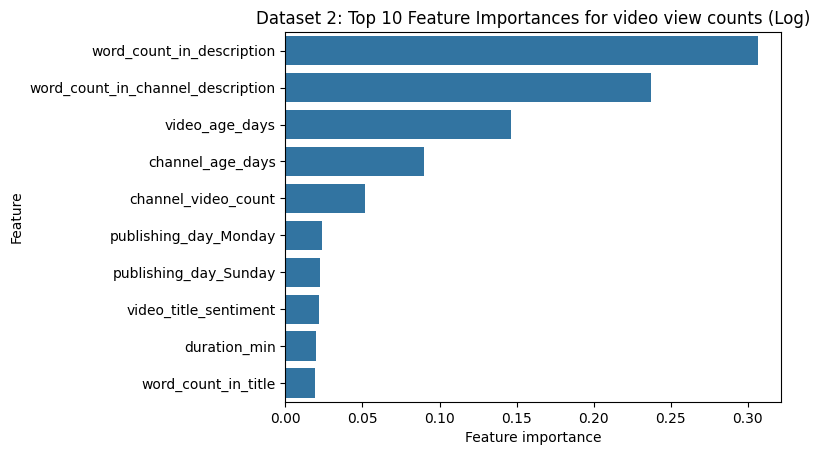

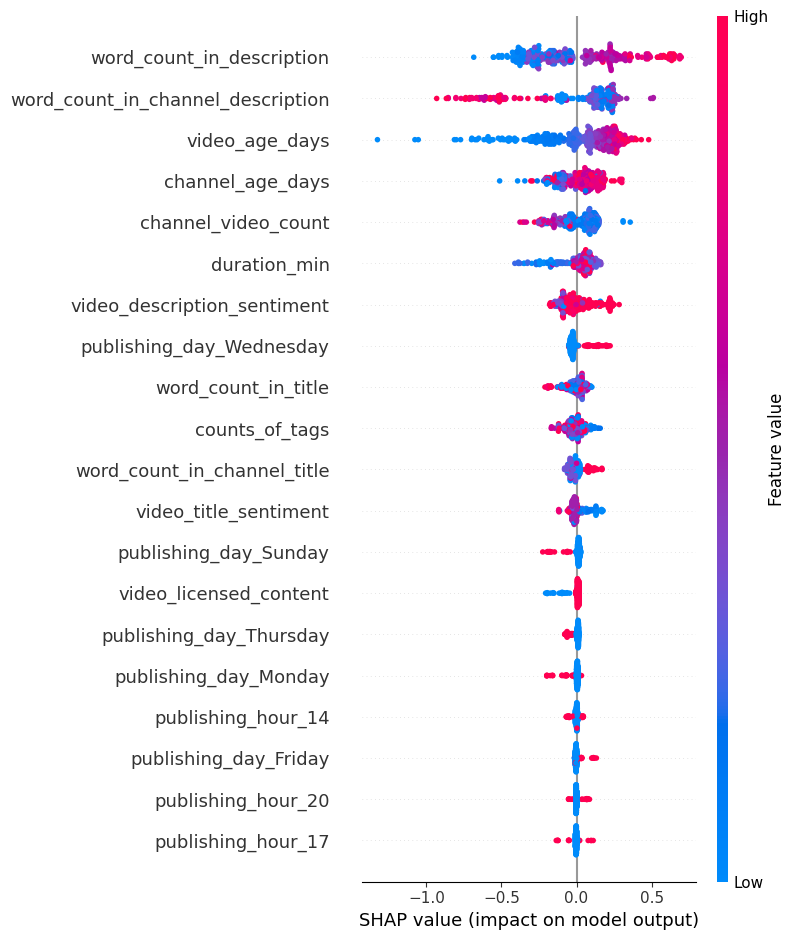

In [138]:
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)
cat_model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.1,
                             depth=6,
                             eval_metric='MAE',
                             random_seed=9,
                             logging_level='Silent',)
cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)
y_pred = cat_model.predict(test_pool)   
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 
print(f'R^2: {r2}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')  


feature_importances = cat_model.get_feature_importance(prettified=True)
feature_importance_df = feature_importance_df.sort_values(by='Feature importance', ascending=False)
sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10) )
plt.title('Dataset 2: Top 10 Feature Importances for video view counts (Log)')
plt.show()

shap_values = cat_model.get_feature_importance(type='ShapValues', data=test_pool)
shap.summary_plot(shap_values[:, :-1], X_test)   


In [107]:
X = df_catboost_model
y = df_output['engaging_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [109]:
for col in catboost_categorical_cols:
    X_train[col] = X_train[col].fillna('unknown').astype(str)
    X_test[col] = X_test[col].fillna('unknown').astype(str)

R^2: 0.9981894477676537
MAE: 1882.128618193436
MSE: 9802334.890015233
RMSE: 3130.8680729176745


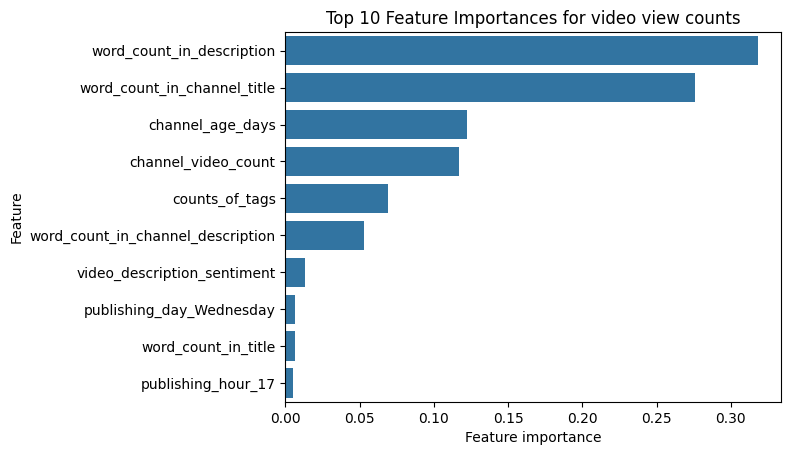

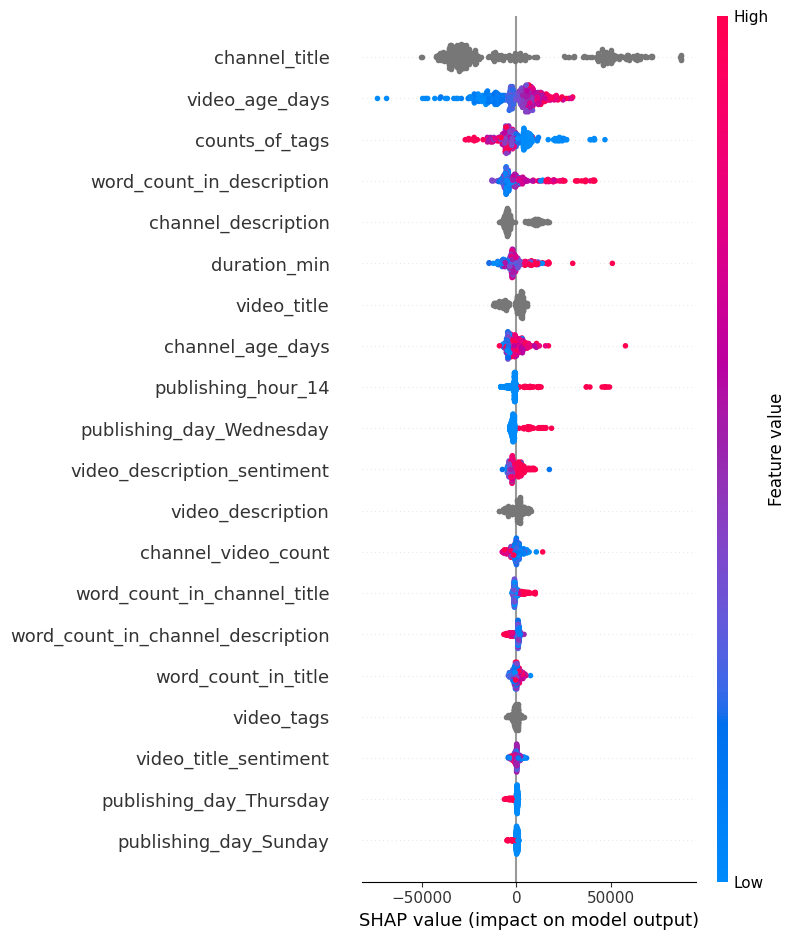

In [110]:
train_pool = Pool(data=X_train, label=y_train, cat_features=catboost_categorical_cols)
test_pool = Pool(data=X_test, label=y_test, cat_features=catboost_categorical_cols)
cat_model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.1,
                             depth=6,
                             eval_metric='MAE',
                             random_seed=9,
                             logging_level='Silent',)
cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)
y_pred = cat_model.predict(test_pool)   
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 
print(f'R^2: {r2}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')  


feature_importances = cat_model.get_feature_importance(prettified=True)
feature_importance_df = feature_importance_df.sort_values(by='Feature importance', ascending=False)
sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10) )
plt.title('Top 10 Feature Importances for video view counts')
plt.show()

shap_values = cat_model.get_feature_importance(type='ShapValues', data=test_pool)
shap.summary_plot(shap_values[:, :-1], X_test)   


In [114]:
X = df_catboost_model
y = df_output['channel_subscriber_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [115]:
for col in catboost_categorical_cols:
    X_train[col] = X_train[col].fillna('unknown').astype(str)
    X_test[col] = X_test[col].fillna('unknown').astype(str)

R^2: 0.9999265627266475
MAE: 27306.782617392444
MSE: 4851327592.477013
RMSE: 69651.47229224241


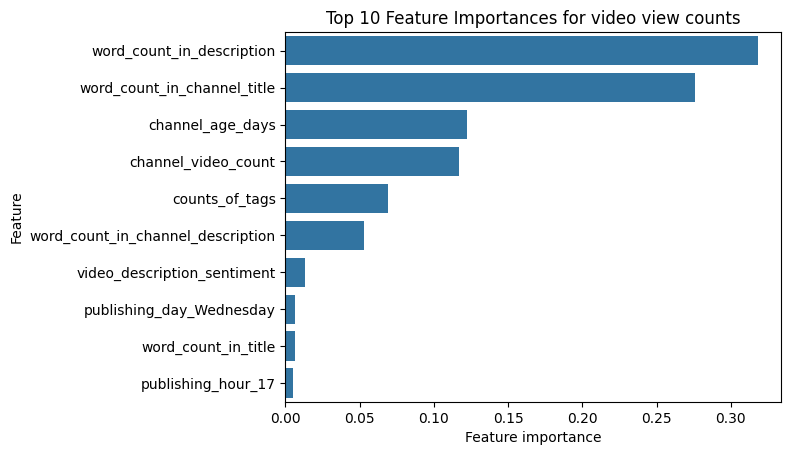

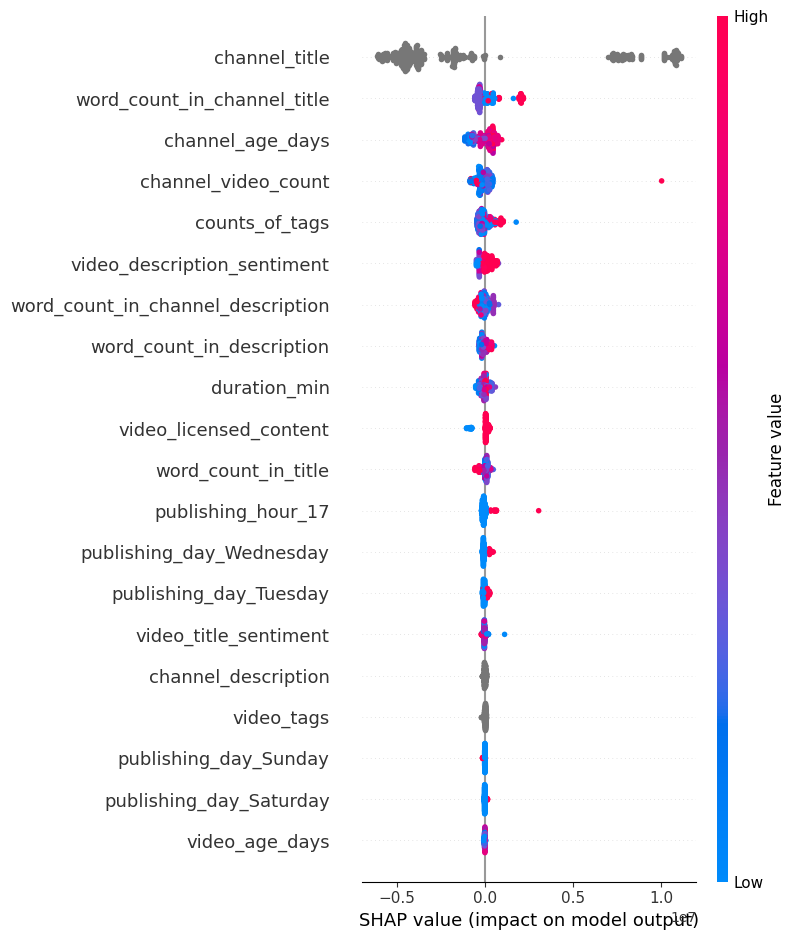

In [116]:
train_pool = Pool(data=X_train, label=y_train, cat_features=catboost_categorical_cols)
test_pool = Pool(data=X_test, label=y_test, cat_features=catboost_categorical_cols)
cat_model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.1,
                             depth=6,
                             eval_metric='MAE',
                             random_seed=9,
                             logging_level='Silent',)
cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)
y_pred = cat_model.predict(test_pool)   
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 
print(f'R^2: {r2}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')  


feature_importances = cat_model.get_feature_importance(prettified=True)
feature_importance_df = feature_importance_df.sort_values(by='Feature importance', ascending=False)
sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10) )
plt.title('Top 10 Feature Importances for video view counts')
plt.show()

shap_values = cat_model.get_feature_importance(type='ShapValues', data=test_pool)
shap.summary_plot(shap_values[:, :-1], X_test)   
